# Training of a Hedgie Tracker: An Exploration of Training Techniques to Avoid Overfitting

Segmentation is the process of seperating an object of interest from the background. It is a common first step in computer vision tasks such as identifying signs and pedestrians for self-driving cars or tracking tumour size in medical MRI. Segmentation is also a fundamentally challenging problem as it is not clearly defined mathematically and therefore segmentation algorithms are often empirical with parameters that must be tuned to specifiy the object of interest. This empirical nature make segmentation a natural fit for deep learning, which takes in images with user defined labels specifying explicitly the object(s) of interest.

There has been much work exploring how different deep learning architectures are currently being used for improved image segmentation, many of these are surveyed in this review: [Medical Image Segmentation Using Deep Learning:
A Survey](https://arxiv.org/pdf/2009.13120.pdf). In this tutorial, we look at one narrow aspect of contemporary deep learning practices, which is training strategies, in particular how to avoid overfitting. Traditionally, the best way to avoid overfitting is to simply add more data to train on. But due to the high cost of quality annotated data, that is in

In [1]:
import matplotlib.pyplot as plt
from fastai.vision.all import *
from scipy.ndimage.interpolation import zoom

from hedgiefinder import HedgieFinder
from hedgiefinder.inference import alpha_mask

In [2]:
base_path = Path('.').absolute().parent.parent
path = base_path / 'data' / 'train'
test_path = path.parent/'test'
fnames = get_image_files(path/'images')
print('example file name:', fnames[0])
print('of', len(fnames), 'training examples')

example file name: D:\Dev\hedgehog_finder\data\train\images\1\1.png
of 240 training examples


## Define DataLoaders

In [3]:
from hedgiefinder.dataloading import get_msk

HD dimensions of video are 1920 x 1088, but if connection is poor it downgrades to SD which is 640 x 360, thus it makes sense to convert all videos to the smaller size to best handle any input

In [4]:
def get_dls_norm(bs=6, size=224, stats=None):
    codes = ['Background', 'Hog', 'Outline']
    normalize_method = Normalize.from_stats(*stats) if stats else Normalize
    hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                       get_items=get_image_files,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_y=get_msk,
                       batch_tfms=[*aug_transforms(do_flip=False),  normalize_method],
                       item_tfms=Resize(size, method='squish'))

    return hogvid.dataloaders(path / 'images', path=path, bs=bs)

In [5]:
dls_norm = get_dls_norm()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
x, y = dls_norm.one_batch()
x.mean(), x.std()

(TensorImage(0.1407, device='cuda:0'), TensorImage(0.9710, device='cuda:0'))

In [7]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Based on the assumption that data should have mean = 0, standard deviation 1 that suggests bare Normalize is better, but using ImageNet would be more generalizable

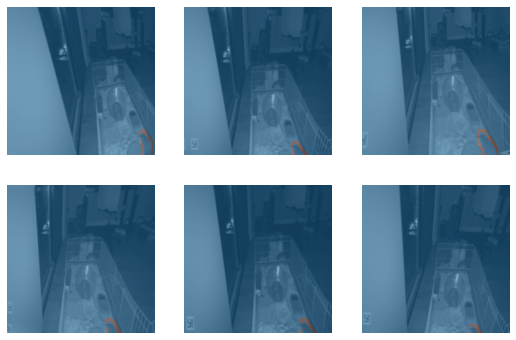

In [8]:
dls_norm.show_batch(unique=True)

In [9]:
x, y = dls_norm.one_batch()
x.shape, y.shape

(torch.Size([6, 3, 224, 224]), torch.Size([6, 224, 224]))

In [10]:
def load_model(dls, model_name, append=False):
    CSV_callback=partial(CSVLogger, fname=f'{model_name}_history', append=append)
    return unet_learner(dls, resnet34, cbs=[ShowGraphCallback(), CSV_callback()], metrics=[foreground_acc])

In [11]:
test_images = get_image_files(test_path / 'images')
print(len(test_images), 'test images')

13 test images


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=3.0199516913853586e-05)

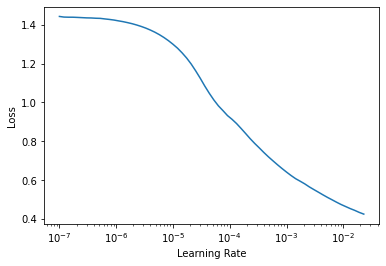

In [12]:
norm_learner = load_model(get_dls_norm(8, 224), 'norm')
norm_learner.lr_find()

In [13]:
1e-5

1e-05

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,foreground_acc,time
0,0.169386,0.040271,0.000000,00:19


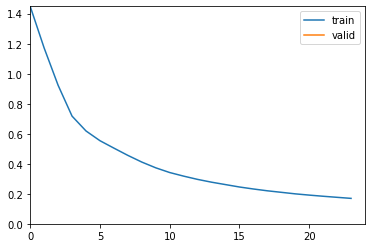

epoch,train_loss,valid_loss,foreground_acc,time
0,0.037088,0.032374,0.000000,00:20
1,0.032499,0.022600,0.000000,00:20
2,0.028050,0.025173,0.267311,00:20
3,0.024262,0.018282,0.411699,00:20
4,0.021507,0.014268,0.444498,00:20
5,0.019434,0.013608,0.469181,00:20
6,0.017117,0.018510,0.671487,00:20
7,0.015371,0.011620,0.590288,00:20
8,0.013375,0.012643,0.582905,00:20
9,0.011938,0.010984,0.708268,00:20


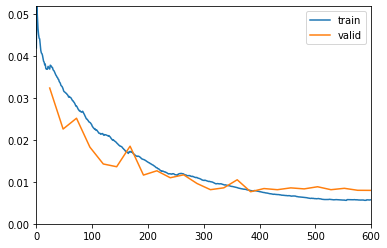

In [14]:
norm_learner = load_model(get_dls_norm(8, 224), 'norm')
norm_learner.fine_tune(25)

In [15]:
dls_imagenet_norm = get_dls_norm(8 ,224, stats=imagenet_stats)
x, y = dls_imagenet_norm.one_batch()
x.mean(), x.std()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


(TensorImage(-0.5015, device='cuda:0'), TensorImage(1.0395, device='cuda:0'))

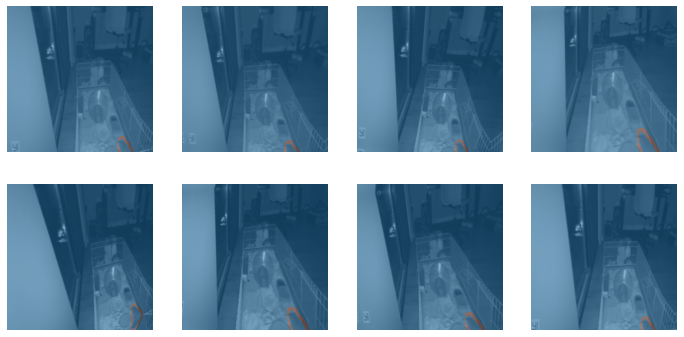

In [16]:
dls_imagenet_norm.show_batch(unique=True)

epoch,train_loss,valid_loss,foreground_acc,time
0,0.151201,0.041523,0.000000,00:20


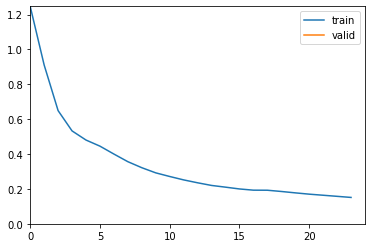

epoch,train_loss,valid_loss,foreground_acc,time
0,0.038780,0.028352,0.000000,00:21
1,0.032441,0.022226,0.003250,00:20
2,0.026926,0.024415,0.541632,00:20
3,0.023053,0.014216,0.507702,00:21
4,0.020488,0.018763,0.410467,00:21
5,0.018203,0.017020,0.489834,00:21
6,0.016427,0.013067,0.524795,00:22
7,0.014429,0.012992,0.561312,00:22
8,0.012905,0.010930,0.654230,00:22
9,0.011467,0.009859,0.747672,00:23


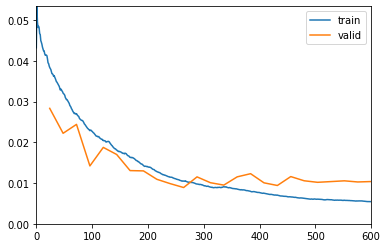

In [17]:
imagenet_norm_learner = load_model(dls_imagenet_norm, 'norm')
imagenet_norm_learner.fine_tune(25)

## The addition of ImageNet normalization made a huge difference!!

With the simple addition of ImageNet normalization, we see that the validation curve better follows the training loss curve, meaning that what the model is learning is generalizable to other data. In addition the model accuracy is 10-20 percentage points higher than before! 73% vs 53%!

We do start to see some overfitting potentially as the validation loss curve exceeds the train curve, however this is desirable to some degree as it means we are not under-fitting.

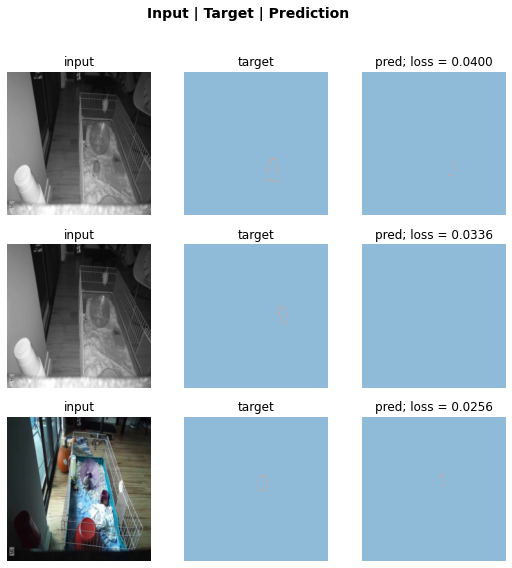

In [18]:
interp = SegmentationInterpretation.from_learner(norm_learner)
interp.plot_top_losses(k=3)

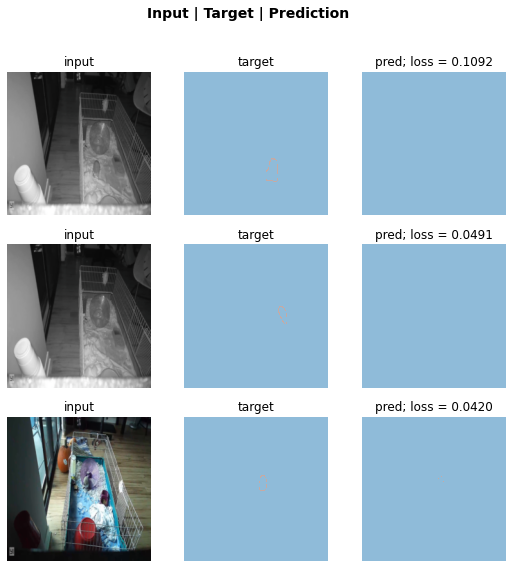

In [19]:
interp = SegmentationInterpretation.from_learner(imagenet_norm_learner)
interp.plot_top_losses(k=3)

In [20]:
def show_overlay(learner, test_im, fname=None):
    original = plt.imread(test_im)
    pred_small = learner.predict(test_im)[0]
    pred = zoom(pred_small, np.array(original.shape[:-1])/np.array(pred_small.shape))
    overlay = alpha_mask(original, pred)

    f, axs = plt.subplots(1,1, figsize=(16,16))
    axs.imshow(overlay)
    if fname:
        plt.savefig(fname)
    plt.show()
    return overlay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


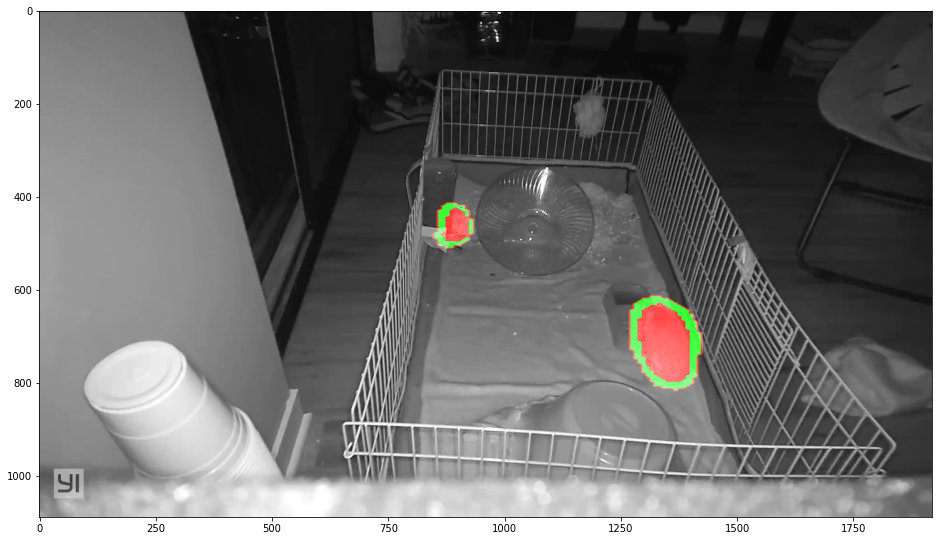

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


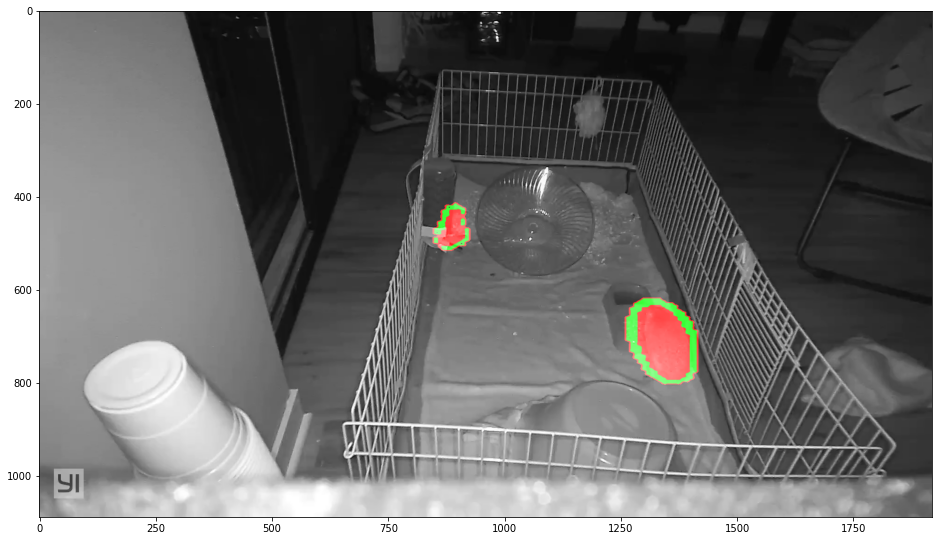

In [21]:
test_im = test_images[1]
no_norm_im = show_overlay(norm_learner, test_im, 'no_norm.png')
norm_im = show_overlay(imagenet_norm_learner, test_im, 'norm.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


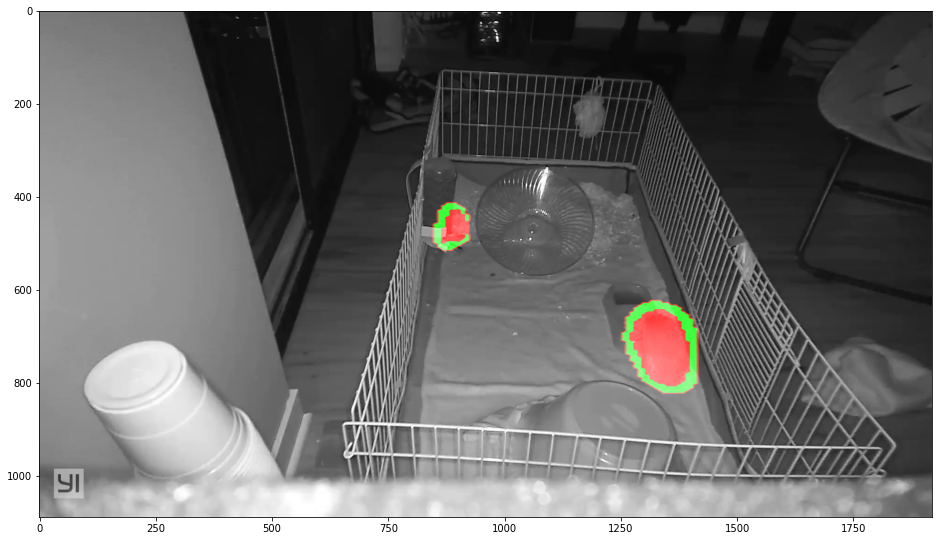

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


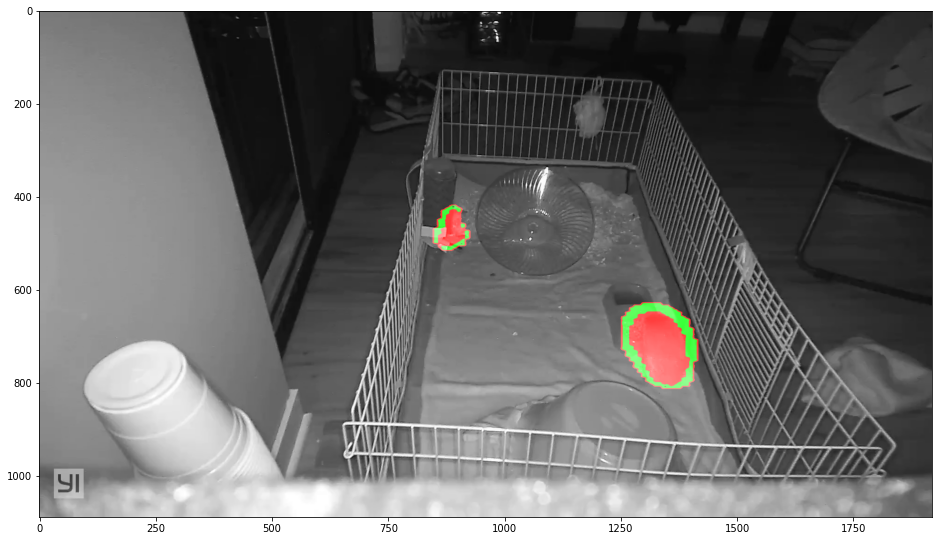

In [22]:
test_im = test_images[12]
no_norm_im = show_overlay(norm_learner, test_im, 'no_norm.png')
norm_im = show_overlay(imagenet_norm_learner, test_im, 'norm.png')

That aint right...

In [23]:
base_path

Path('D:/Dev/hedgehog_finder')

In [24]:
from datetime import datetime
model_name = f"{datetime.now().strftime('%Y%m%d_%H%M')}_{'norm'}"
model_name

'20210402_2043_norm'

In [25]:
norm_learner.remove_cb(CSVLogger)
norm_learner.save(model_name)

Path('D:/Dev/hedgehog_finder/data/train/models/20210402_2043_norm.pth')

In [29]:
doc(norm_learner.export)

Learner.export [source] Learner.export ( fname = 'export.pkl' , pickle_module = pickle , pickle_protocol = 2 ) 
 
 Export the content of self without the items and the optimizer state for inference 
 Show in docs

In [30]:
doc(norm_learner.save)

Learner.save [source] Learner.save ( file , with_opt = True , pickle_protocol = 2 ) 
 
 Save model and optimizer state (if with_opt ) to self.path/self.model_dir/file 
 Show in docs